<a href="https://colab.research.google.com/github/danoAasland/SP500_ML_Python/blob/master/SP500model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

REQUIRED TO ESTABLISH ENVIRONMENT

In [1]:
#Required to scrape financial data from Yahoo Stock Market
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.52-py2.py3-none-any.whl size=21997 sha256=0d14ec63b451d802379e195df058a3334b173c23bb95552744858666059126e3
  Stored in directory: /root/.cache/pip/wheels/1b/9d/ce/929e851fc7d649cd962c177220ad985675785aa97c54df5714
Successfully built yfinance


In [0]:
#Libraries
from datetime import datetime
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#model imports
from sklearn import tree #decision tree model
from sklearn.linear_model import LogisticRegression #Logistic Regression
from sklearn.linear_model import LinearRegression #Linear Regression
from sklearn.ensemble import AdaBoostClassifier #Boosted Tree Classifier
from sklearn.tree import DecisionTreeClassifier #Two Class Tree Classifier
from sklearn.ensemble import RandomForestClassifier #Random Forest Classifier
#graphing
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
sns.set(style="darkgrid")

HELPER FUNCTIONS

In [0]:
#function to calc Profit and Loss, and Outcome (+/- valuation for timeframe)
#inputs are as follows:
#cols = Date, Open, High, Low, Close, Volume, Feat1, Feat2; this is extracted from the dataframe
#predArr = output from predict function of given model

def modelEvalParams(DF, predArr, probFlag= None):
  funcDF = DF.copy()
  # create +/- Day col
  #funcDF['Outcome'] = funcDF.apply(lambda x: 1 if x['Close'] > x['Open'] else -1, axis=1)

  if probFlag == 'reg':
    tempList = []
    for i in range(0, len(predArr)):
      if predArr[i] >= 0.5:
        tempList.append(1)
      else:
        tempList.append(-1)

    funcDF['Outcome'] = funcDF.apply(lambda x: 1 if x['Close'] > x['Open'] else -1, axis=1)
    funcDF['Predictions'] = tempList
    funcDF['AccMetric'] = np.where(funcDF['Predictions'] == funcDF['Outcome'], 1, 0)

  elif probFlag == 'probEval':
    funcDF['ProbNegTrade'] = extractFrstVal(predArr)
    funcDF['ProbPlusTrade'] = extractSecVal(predArr)
    funcDF['Predictions'] = funcDF.apply(lambda x: 1 if x['ProbPlusTrade'] > x['ProbNegTrade'] else -1, axis=1)
    funcDF['Outcome'] = funcDF.apply(lambda x: 1 if x['Close'] > x['Open'] else -1, axis=1)
    funcDF['AccMetric'] = np.where(funcDF['Predictions'] == funcDF['Outcome'], 1, 0)
  
  elif probFlag == 'lrProb':
    funcDF['Predictions'] = predArr.ravel()
    funcDF['Predictions'] = funcDF['Predictions'].apply(lambda x: 1 if x > 0.5 else -1)
    funcDF['Outcome'] = funcDF.apply(lambda x: 1 if x['Close'] > x['Open'] else -1, axis=1)
    funcDF['AccMetric'] = np.where(funcDF['Predictions'] == funcDF['Outcome'], 1, 0)
    
  else:
    #pass predicted values to dataframe
    funcDF['Predictions'] = predArr.ravel()
    funcDF['Outcome'] = funcDF.apply(lambda x: 1 if x['Close'] > x['Open'] else -1, axis=1)
    funcDF['AccMetric'] = np.where(funcDF['Predictions'] == funcDF['Outcome'], 1, 0)
  # profit vs loss value
  funcDF['pnl'] = funcDF['Close'] - funcDF['Open']
  return funcDF

In [0]:
#Function takes in the test dataframe, y-predicted values (array), model type (String input)

def modelPerfMeasures(DF, mdlTyp, probFlag=None):
  funcDF = DF.copy() #copy of dataframe to be modified

  if probFlag == 'prob':
    yPredict = funcDF.apply(lambda x: 1 if x['ProbPlusTrade'] > x['ProbNegTrade'] else -1, axis=1)
    funcDF['Predictions'] = yPredict
    yTrue = funcDF['Outcome'].ravel()

  else:
    yPredict = funcDF['Predictions'].ravel()
    yTrue = funcDF['Outcome'].ravel()

  #Sharpe Ratio Calc 
  pnlMean = funcDF['pnl'].mean()
  pnlStd = funcDF['pnl'].std()
  daysTraded = len(funcDF['pnl'])
  sharpesharpeRatio = (np.sqrt(daysTraded)*(pnlMean/pnlStd))
  
  # multiplies each transaction by 2 to account for Buy and Sell actions
  roundTurns = 2 * daysTraded
  
  #1st and Last trade day dates
  funcDF = funcDF.reset_index(drop=True)
  endDate = len(funcDF)-1
  lastTradeDay = funcDF['Date'][endDate]
  try:
    firstTradeDay = funcDF['Date'][0]
  except:
    firstTradeDay = funcDF['Date'][1]
  
  #total return
  totalReturnVal = funcDF['pnl'].sum()
  
  #Confusion Matrix
  try:
    tn, fp, fn, tp = confusion_matrix(yTrue, yPredict).ravel()
  except:
    pass
  
  #Model selection print values 
  if mdlTyp == 'LR':
    #Acc, Prec, Recall - Linear Regression
    eval = accuracy_score(yTrue, yPredict)
    print("Accuracy of Linear Regression Model is %f" %(eval))
    try:
      precScore = tp/(tp + fp)
      recallScore = tp/(tp + fn)
      print("Precision of Linear Regression Model is %f" %(precScore))
      print("Recall of Linear Regression Model is %f" %(recallScore))
    except:
      pass
    
  elif mdlTyp == 'BDT':
    #Acc, Prec, Recall - Boosted Tree Classifier
    eval = accuracy_score(yTrue, yPredict)
    print("Accuracy of Boosted Tree Model is %f" %(eval))
    try:
      precScore = tp/(tp + fp)
      recallScore = tp/(tp + fn)
      print("Precision of Boosted Tree Model is %f" %(precScore))
      print("Recall of Boosted Tree Model is %f" %(recallScore))
    except:
      pass

  elif mdlTyp == 'RFC':
    #Acc, Prec, Recall - Random Forest Classifier
    eval = accuracy_score(yTrue, yPredict)
    print("Accuracy of Random Forest Model is %f" %(eval))
    try:
      precScore = tp/(tp + fp)
      recallScore = tp/(tp + fn)
      print("Precision of Random Forest Model is %f" %(precScore))
      print("Recall of Random Forest Model is %f" %(recallScore))
    except:
      pass

  elif mdlTyp == 'DT':
    #Acc, Prec, Recall - Decision Tree Classifier
    eval = accuracy_score(yTrue, yPredict)
    print("Accuracy of Decision Tree Model is %f" %(eval))
    try:
      precScore = tp/(tp + fp)
      recallScore = tp/(tp + fn)
      print("Precision of Decision Tree Model is %f" %(precScore))
      print("Recall of Decision Tree Model is %f" %(recallScore))
    except:
      pass

  elif mdlTyp ==  'LC':
    #Acc, Prec, Recall - Logistic Classifier
    eval = accuracy_score(yTrue, yPredict)
    print("Accuracy of Logistic Classifier Model is %f" %(eval))
    try:
      precScore = tp/(tp + fp)
      recallScore = tp/(tp + fn)
      print("Precision of Logistic Classifier Model is %f" %(precScore))
      print("Recall of Logistic Classifier Model is %f" %(recallScore))
    except:
      pass

  else:
    print("***Model Type Error***")

  print('Mean of PnL is %f' %(pnlMean))
  print('Standard Dev of PnL is %f' % (pnlStd))
  print('Sharpe is %f' % (sharpesharpeRatio))
  print('Round turns is %f' % (roundTurns))
  print('First trading day {}'.format(firstTradeDay))
  print('Last trading day {}'.format(lastTradeDay))
  print('Total return %f' % (totalReturnVal))
  #print('Confusion Matrix Values: ', tn, fp, fn, tp)

  #return only rows where we placed a trade
  funcDF = funcDF[funcDF['Predictions'] == 1]
  #cumulative sum of returns
  funcDF['CumSumPnL'] = np.cumsum(funcDF['pnl'])

  # Plot the gains from predictions
  ax = plt.axes()
  sns.lineplot(x="Date", y="CumSumPnL", data= funcDF)
  ax.set_title("Cumulative Point Gains")
  plt.show()


In [0]:
# This is a helper function to trade 1 bar (for example 1 day) with a Buy order at opening session
# and a Sell order at closing session. To protect against adverse movements of the price, a STOP order
# will limit the loss to the stop level (stop parameter must be a negative number)
# each bar must contains the following attributes: 
# Open, High, Low, Close prices as well as gain = Close - Open and lo = Low - Open

def trade_with_stop(bar, slippage = 0, stop=None):
    """
    Given a bar, with a gain obtained by the closing price - opening price
    it applies a stop limit order to limit a negative loss
    If stop is equal to None, then it returns bar['gain']
    """
    bar['Gain'] = bar['Gain'] - slippage
    if stop != None:
        real_stop = stop - slippage
        if bar['Lo']<=stop:
            return real_stop
    # stop == None    
    return bar['Gain']

In [0]:
#extracts first value from all lists within nested probability list
def extractFrstVal(lst): 
    return [item[0] for item in lst] 

In [0]:
#extracts second value from all lists within nested probability list
def extractSecVal(lst): 
    return [item[1] for item in lst] 

DATA ACQUISITION

In [0]:
#Assign SP500 date to var, pulls stock data by finance symbol
stock = yf.Ticker('^GSPC')

In [9]:
#Get stocks info
stock.info

{'algorithm': None,
 'ask': 3194.58,
 'askSize': 0,
 'averageDailyVolume10Day': 3620278333,
 'averageVolume': 3520532187,
 'averageVolume10days': 3620278333,
 'beta': None,
 'bid': 3193.87,
 'bidSize': 0,
 'circulatingSupply': None,
 'currency': 'USD',
 'dayHigh': 3198.22,
 'dayLow': 3191.03,
 'dividendRate': None,
 'dividendYield': None,
 'exDividendDate': None,
 'exchange': 'SNP',
 'exchangeTimezoneName': 'America/New_York',
 'exchangeTimezoneShortName': 'EST',
 'expireDate': None,
 'fiftyDayAverage': 3108.0237,
 'fiftyTwoWeekHigh': 3198.22,
 'fiftyTwoWeekLow': 2346.58,
 'fiveYearAvgDividendYield': None,
 'forwardPE': None,
 'fromCurrency': None,
 'gmtOffSetMilliseconds': '-18000000',
 'isEsgPopulated': False,
 'lastMarket': None,
 'logo_url': '',
 'market': 'us_market',
 'marketCap': None,
 'maxAge': 1,
 'maxSupply': None,
 'messageBoardId': 'finmb_INDEXGSPC',
 'navPrice': None,
 'open': 3195.4,
 'openInterest': None,
 'payoutRatio': None,
 'previousClose': 3191.45,
 'priceHint': 2,

In [10]:
#Scrape Yahoo Finance Function
data = yf.download('^GSPC', period= 'ytd', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [11]:
data.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,2476.959961,2519.489990,2467.469971,2510.030029,2510.030029,3733160000
2019-01-03,2491.919922,2493.139893,2443.959961,2447.889893,2447.889893,3822860000


In [0]:
#set index to standard numeric and convert 'Date' to column
data.reset_index(inplace=True)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 7 columns):
Date         243 non-null datetime64[ns]
Open         243 non-null float64
High         243 non-null float64
Low          243 non-null float64
Close        243 non-null float64
Adj Close    243 non-null float64
Volume       243 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 13.4 KB


In [0]:
#drop 'Adj Close'
data.drop('Adj Close', inplace=True, axis=1)

In [0]:
#save finance dataframe to csv
data.to_csv('yahooFinanceML.csv', index= False)

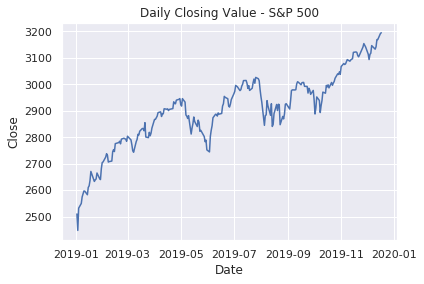

In [16]:
# Plot of Closing Values for S&P 500
ax = plt.axes()
sns.lineplot(x="Date", y="Close", data= data)
ax.set_title('Daily Closing Value - S&P 500')
plt.show()


BASIC FEATURE GENERATION

In [0]:
#add the outcome variable, 1 if the trading session was positive (close>open), -1 otherwise
data['Outcome'] = np.where(data['Close'] > data['Open'], 1, -1)

In [0]:
#add three new columns ‘Ho’ ‘Lo’ and ‘Gain’
#to backtest the model later
data['Ho'] = data['High'] - data['Open'] #distance between Highest and Opening price
data['Lo'] = data['Low'] - data['Open'] #distance between Lowest and Opening price
data['Gain'] = data['Close'] - data['Open'] #distance between open and close price

In [0]:
# GENERATE LAGGED TIMESERIES
timeSeriesDay1 = data.copy().shift(1) # by 1 day
timeSeriesDay2 = data.copy().shift(2) # by 2 days

In [0]:
#2 Engineered Features to identify if current days close value
# is greater than last 1 and 2 days close value
data['Feat1'] = data['Close'] > timeSeriesDay1['Close']
data['Feat2'] = data['Close'] > timeSeriesDay2['Close']

In [0]:
data['Feat1'] = np.where(data['Feat1'] == True, 1, 0)

In [0]:
data['Feat2'] = np.where(data['Feat2'] == True, 1, 0)

In [23]:
#check to ensure features generated successfully
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 12 columns):
Date       243 non-null datetime64[ns]
Open       243 non-null float64
High       243 non-null float64
Low        243 non-null float64
Close      243 non-null float64
Volume     243 non-null int64
Outcome    243 non-null int64
Ho         243 non-null float64
Lo         243 non-null float64
Gain       243 non-null float64
Feat1      243 non-null int64
Feat2      243 non-null int64
dtypes: datetime64[ns](1), float64(7), int64(4)
memory usage: 22.9 KB


In [0]:
#Create Train and Test datasets 80/20 split
ratio = 0.8
trainDF = data[0:round(len(data)*ratio)]
testDF = data[round(len(data)*ratio):]

In [25]:
trainDF.shape

(194, 12)

In [26]:
testDF.shape

(49, 12)

In [0]:
testDF.reset_index(drop= True, inplace= True)

In [0]:
trainX = trainDF.loc[:, ~trainDF.columns.isin(['Outcome'])]
trainY = trainDF.loc[:, trainDF.columns.isin(['Outcome'])]

In [0]:
testX = testDF.loc[:, ~testDF.columns.isin(['Outcome'])]
testY = testDF.loc[:, testDF.columns.isin(['Outcome'])]

DECISION TREE CLASSIFIER

In [0]:
#assign model to var
decisionTree = tree.DecisionTreeClassifier(max_depth=None)

In [31]:
decisionTree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [32]:
#Fitting model to train data
decisionTree.fit(trainX.drop('Date', axis= 1), trainY)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
yPredictDT = decisionTree.predict(testX.drop('Date', axis= 1))

In [0]:
#model evaluation dataframe
decisionTreeDF = modelEvalParams(testX, yPredictDT)

Accuracy of Decision Tree Model is 0.979592
Precision of Decision Tree Model is 1.000000
Recall of Decision Tree Model is 0.967742
Mean of PnL is 3.394471
Standard Dev of PnL is 10.127557
Sharpe is 2.346203
Round turns is 98.000000
First trading day 2019-10-09 00:00:00
Last trading day 2019-12-17 00:00:00
Total return 166.329102


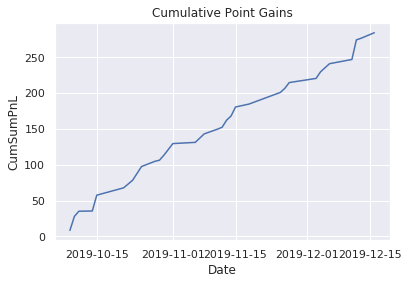

In [35]:
modelPerfMeasures(decisionTreeDF, 'DT')

In [0]:
SLIPPAGE = 0.6
STOP = -3
trades = decisionTreeDF[decisionTreeDF['Predictions'] == 1][['Date', 'Gain', 'Ho', 'Lo', 'Open', 'Close']]

In [0]:
trades['pnl'] = trades.apply(lambda x: trade_with_stop(x, slippage=SLIPPAGE, stop=STOP), axis=1)

In [0]:
trades['pnl'] = np.cumsum(trades['pnl'])

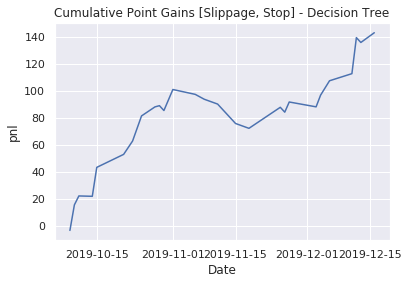

In [39]:
# Plot the gains from predictions
ax = plt.axes()
sns.lineplot(x="Date", y="pnl", data= trades)
ax.set_title("Cumulative Point Gains [Slippage, Stop] - Decision Tree")
plt.show()

In [40]:
print("Slippage is %s, STOP level at %s" % (SLIPPAGE, STOP))

Slippage is 0.6, STOP level at -3


PREDICTING PROBABILITY - DECISION TREE

In [0]:
probDT = decisionTree.predict_proba(testX.drop('Date', axis= 1))

In [42]:
testX.head()

,Date,Open,High,Low,Close,Volume,Ho,Lo,Gain,Feat1,Feat2
0,2019-10-09,2911.100098,2929.320068,2907.409912,2919.399902,2726820000,18.219971,-3.690186,8.299805,1,0
1,2019-10-10,2918.550049,2948.459961,2917.120117,2938.129883,3217250000,29.909912,-1.429932,19.579834,1,1
2,2019-10-11,2963.070068,2993.280029,2963.070068,2970.270020,3580460000,30.209961,0.000000,7.199951,1,1
3,2019-10-14,2965.810059,2972.840088,2962.939941,2966.149902,2557020000,7.030029,-2.870117,0.339844,0,1
4,2019-10-15,2973.610107,3003.280029,2973.610107,2995.679932,3340740000,29.669922,0.000000,22.069824,1,1


In [0]:
#model evaluation dataframe
probDecisionTreeDF = modelEvalParams(testX, probDT, probFlag='probEval')

Accuracy of Decision Tree Model is 0.979592
Precision of Decision Tree Model is 1.000000
Recall of Decision Tree Model is 0.967742
Mean of PnL is 3.394471
Standard Dev of PnL is 10.127557
Sharpe is 2.346203
Round turns is 98.000000
First trading day 2019-10-09 00:00:00
Last trading day 2019-12-17 00:00:00
Total return 166.329102


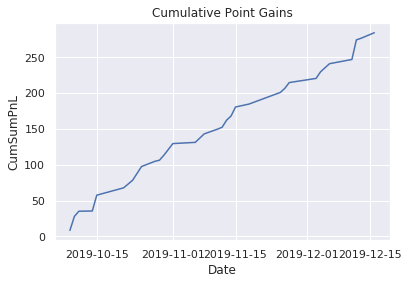

In [46]:
modelPerfMeasures(probDecisionTreeDF, 'DT', probFlag=True)

In [0]:
pnlProb = probDecisionTreeDF[probDecisionTreeDF['Predictions'] == 1]['Gain'] # the gain column contains (Close - Open) values

In [0]:
drawdown = pnlProb - np.maximum.accumulate(pnlProb)
max_drawdown = min(drawdown)

In [49]:
max_drawdown

-25.18994140625

In [0]:
#bar = data
#slippage = 0 - 1 decimal value to represent cost of trans
#stop = lowest tolerated "point" deviation
#mult = Dollar value per share
#commission = Broker cost for trade
#probability threshold to select positive day/signal to initiate trade at open and sell at close
#target = outcome col class
def backTestGain(bar, slippage = 0, stop= None, MULT = 25, COMMISSION = 1, threshold = 0.5):
  bar['NetGain'] = (bar['Gain'] - slippage) * MULT - (2 * COMMISSION)
  bar = bar[bar['ProbPlusTrade'] >= threshold]
  if stop != None:
    real_stop = stop - slippage
    if bar['Lo']<=stop:
      return real_stop
  return bar

In [0]:
probDecisionTreeDF = backTestGain(probDecisionTreeDF)

Accuracy of Decision Tree Model is 1.000000
Mean of PnL is 9.472632
Standard Dev of PnL is 6.451211
Sharpe is 8.042481
Round turns is 60.000000
First trading day 2019-10-09 00:00:00
Last trading day 2019-12-16 00:00:00
Total return 284.178955


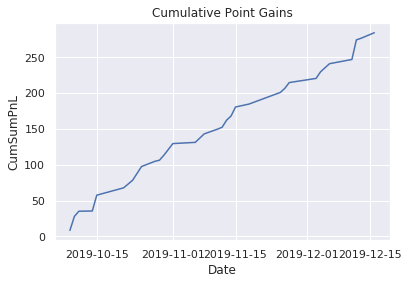

In [52]:
modelPerfMeasures(probDecisionTreeDF, 'DT', probFlag='prob')

LOGISTIC CLASSIFIER

In [0]:
modelLC = LogisticRegression(solver= 'lbfgs')

In [54]:
modelLC.fit(trainX.drop('Date', axis=1), trainY.Outcome)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
probLC = modelLC.predict_proba(testX.drop('Date', axis= 1))

In [0]:
#model evaluation dataframe
probLCDF = modelEvalParams(testX, probLC, probFlag='probEval')

Accuracy of Logistic Classifier Model is 0.632653
Precision of Logistic Classifier Model is 0.632653
Recall of Logistic Classifier Model is 1.000000
Mean of PnL is 3.394471
Standard Dev of PnL is 10.127557
Sharpe is 2.346203
Round turns is 98.000000
First trading day 2019-10-09 00:00:00
Last trading day 2019-12-17 00:00:00
Total return 166.329102


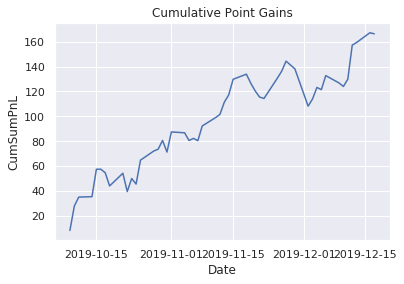

In [57]:
modelPerfMeasures(probLCDF, 'LC', probFlag='prob')

In [0]:
pnlProb = probLCDF[probLCDF['Predictions'] == 1]

In [0]:
SLIPPAGE = 0
STOP = -3
pnlProb['pnl'] = pnlProb.apply(lambda x: trade_with_stop(x, slippage=SLIPPAGE, stop=STOP), axis= 1)

In [0]:
pnlProb['pnl'] = np.cumsum(pnlProb['pnl'])

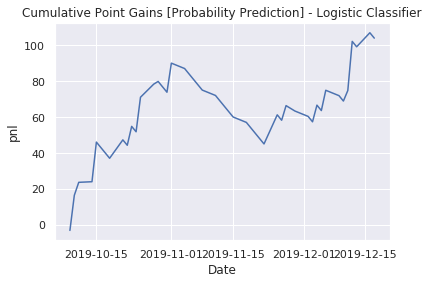

In [61]:
# Plot the gains from predictions
ax = plt.axes()
sns.lineplot(x="Date", y="pnl", data= pnlProb)
ax.set_title("Cumulative Point Gains [Probability Prediction] - Logistic Classifier")
plt.show()

LINEAR REGRESSION MODEL

In [0]:
modelLR = LinearRegression(normalize=True)

In [63]:
modelLR.fit(trainX.drop('Date', axis= 1), trainY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [0]:
predictLR = modelLR.predict(testX.drop('Date', axis= 1))

In [0]:
predictions_max, predictions_min = max(predictLR), min(predictLR)
predictions_prob = (predictLR - predictions_min)/(predictions_max - predictions_min)

In [66]:
predictions_max, predictions_min

(array([1.21266824]), array([-1.1680154]))

In [0]:
#model evaluation dataframe
modelLRDF = modelEvalParams(testX, predictions_prob, 'lrProb')

Accuracy of Linear Regression Model is 0.755102
Precision of Linear Regression Model is 0.787879
Recall of Linear Regression Model is 0.838710
Mean of PnL is 3.394471
Standard Dev of PnL is 10.127557
Sharpe is 2.346203
Round turns is 98.000000
First trading day 2019-10-09 00:00:00
Last trading day 2019-12-17 00:00:00
Total return 166.329102


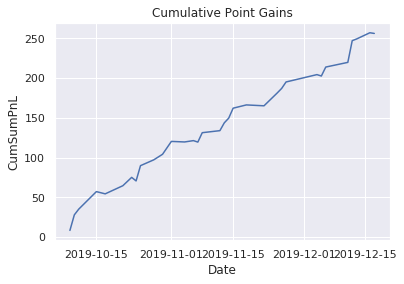

In [68]:
modelPerfMeasures(modelLRDF, 'LR', probFlag=None)

BOOSTED DECISION TREE [ADABOOST]

In [0]:
modelBDT = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=100)

In [70]:
modelBDT.fit(trainX.drop('Date', axis=1), trainY.Outcome)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                               

In [0]:
predictBDT = modelBDT.predict(testX.drop('Date', axis=1))

In [0]:
#model evaluation dataframe
modelBDTDF = modelEvalParams(testX, predictBDT)

Accuracy of Boosted Tree Model is 0.979592
Precision of Boosted Tree Model is 1.000000
Recall of Boosted Tree Model is 0.967742
Mean of PnL is 3.394471
Standard Dev of PnL is 10.127557
Sharpe is 2.346203
Round turns is 98.000000
First trading day 2019-10-09 00:00:00
Last trading day 2019-12-17 00:00:00
Total return 166.329102


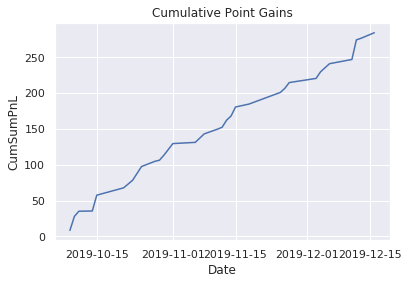

In [73]:
modelPerfMeasures(modelBDTDF, 'BDT')

RANDOM FOREST CLASSIFIER

In [0]:
modelRandF = RandomForestClassifier(max_depth=2, n_estimators=10, random_state=0)

In [75]:
modelRandF.fit(trainX.drop('Date', axis=1), trainY.Outcome)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
predictRandF = modelRandF.predict(testX.drop('Date', axis=1))

In [0]:
#model evaluation dataframe
modelRFDF = modelEvalParams(testX, predictRandF)

Accuracy of Random Forest Model is 0.979592
Precision of Random Forest Model is 1.000000
Recall of Random Forest Model is 0.967742
Mean of PnL is 3.394471
Standard Dev of PnL is 10.127557
Sharpe is 2.346203
Round turns is 98.000000
First trading day 2019-10-09 00:00:00
Last trading day 2019-12-17 00:00:00
Total return 166.329102


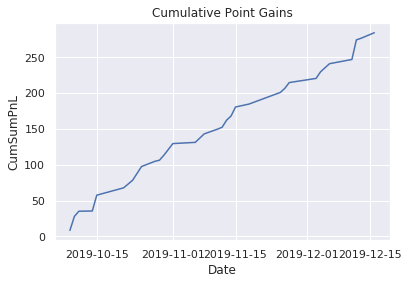

In [78]:
modelPerfMeasures(modelBDTDF, 'RFC')

CUMULATIVE PnL VALUE FOR ALL MODELS

In [0]:
#model evaluation Random Forest
modelRFDF = modelEvalParams(testX, predictRandF)

#model evaluation Boosted Decision Tree [AdaBoost]
modelBDTDF = modelEvalParams(testX, predictBDT)

#model evaluation Linear Regression
modelLRDF = modelEvalParams(testX, predictions_prob, 'lrProb')

#model evaluation dataframe
probLCDF = modelEvalParams(testX, probLC, probFlag='probEval')

#model evaluation Decision Tree
decisionTreeDF = modelEvalParams(testX, yPredictDT)

In [0]:
conCatPnL = pd.concat([modelRFDF['pnl'], modelBDTDF['pnl'], modelLRDF['pnl'], probLCDF['pnl'], decisionTreeDF['pnl']], axis=1)

In [0]:
#conCatPnL

In [0]:
conCatPnL['PnlSum'] = conCatPnL.sum(axis=1)

In [0]:
pnlSumArr = conCatPnL.PnlSum

In [0]:
pnlCumSumArr = np.cumsum(pnlSumArr)

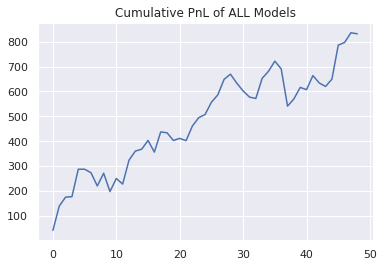

In [85]:
# Plot the gains from predictions
ax = plt.axes()
sns.lineplot(data= pnlCumSumArr)
ax.set_title("Cumulative PnL of ALL Models")
plt.show()

ALL MODELS - PRECISION

In [0]:
def sharpeRatioCalc(DF):
  pnlMean = DF['pnl'].mean()
  pnlStd = DF['pnl'].std()
  daysTraded = len(DF['pnl'])
  sharpeRatio = (np.sqrt(daysTraded)*(pnlMean/pnlStd))
  return sharpeRatio

In [0]:
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_score

In [0]:
def modelAcPrec(DF1):
  dfTemp = []
  dfTemp.append(accuracy_score(DF1.Outcome.values, DF1.Predictions.values))
  dfTemp.append(precision_score(DF1.Outcome.values, DF1.Predictions.values))
  dfTemp.append(sharpeRatioCalc(DF1))
  dfTemp.append(2 * len(DF1['pnl']))
  return dfTemp

In [0]:
linRegres = modelAcPrec(modelLRDF)

In [0]:
ranForest = modelAcPrec(modelRFDF)

In [0]:
boostTree = modelAcPrec(modelBDTDF)

In [0]:
decTree = modelAcPrec(decisionTreeDF)

In [0]:
logRegres = modelAcPrec(probLCDF)

In [94]:
# output trans dataframe, cols are accuracy, precision, sharpe, turns
tempDF = pd.DataFrame()
tempDF['LinearRegress'] = linRegres
tempDF['RandomForest'] = ranForest
tempDF['Boosted Tree'] = boostTree
tempDF['DecisionTree'] = decTree
tempDF['LogisticRegress'] = logRegres
tempDF.T

,0,1,2,3
LinearRegress,0.755102,0.787879,2.346203,98.0
RandomForest,1.000000,1.000000,2.346203,98.0
Boosted Tree,0.979592,1.000000,2.346203,98.0
DecisionTree,0.979592,1.000000,2.346203,98.0
LogisticRegress,0.632653,0.632653,2.346203,98.0


ALL MODEL AGGREGATION

In [0]:
#place models in order from largest singular precision to least
def aggAllModelsFinance(m1, m2, m3, m4, m5):
  m1p = m1[1]
  m2p = m2[1]
  m3p = m3[1]
  m4p = m4[1]
  m5p = m5[1]
  print('One Model Precision: ')
  print(m1p)
  print('Two Models Precision: ')
  print((m1p + m2p) / 2)
  print('Three Models Precision: ')
  print((m1p + m2p + m3p) / 3)
  print('Four Models Precision: ')
  print((m1p + m2p + m3p + m4p) / 4)
  print('Five Models Precision: ')
  print((m1p + m2p + m3p + m4p + m5p) / 5)


In [96]:
aggAllModelsFinance(linRegres, ranForest, boostTree, decTree, logRegres)

One Model Precision: 
0.7878787878787878
Two Models Precision: 
0.8939393939393939
Three Models Precision: 
0.9292929292929294
Four Models Precision: 
0.946969696969697
Five Models Precision: 
0.8841063698206556
